In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import enum
import os

import sys
# sys.path.append( '/content/drive/My Drive/thesis-workspace' ) # drive version
sys.path.append( '../../src/' ) # local version

from ml.preprocessing import *

# Classification

## Loading Datasets

In [2]:
class DF( enum.Enum ):
    _FULL = 1
    _REDUCED_RFE = 2
    _REDUCED_KBEST = 3
    _MIN = 4

# path = [ '.', 'drive', 'My Drive', 'thesis-workspace', 'datasets' ]
path = [ '..', '..', 'datasets', 'feature_selection' ]

df = {}
df[ DF._FULL ] = pd.read_csv( os.path.join( *path, 'ds-gym-fs-full.csv' ) , index_col = 'date', parse_dates = [ 'date' ] )
df[ DF._REDUCED_RFE ] = pd.read_csv( os.path.join( *path, 'ds-gym-fs-rfe.csv' ), index_col = 'date', parse_dates = [ 'date' ] )
df[ DF._REDUCED_KBEST ] = pd.read_csv( os.path.join( *path, 'ds-gym-fs-kbest.csv' ), index_col = 'date', parse_dates = [ 'date' ] )
df[ DF._MIN ] = pd.read_csv( os.path.join( *path, 'ds-gym-fs-min.csv' ), index_col = 'date', parse_dates = [ 'date' ] )

## Data splitting, standarization and balancing

In [3]:
from imblearn.over_sampling import ADASYN
from collections import Counter


# Number of neighbors to use for balancing each dataset

neighbors = { 
    DF._FULL: 1,
    DF._REDUCED_RFE: 1,
    DF._REDUCED_KBEST: 1,
    DF._MIN: 1
}

for k, d in df.items() :  
    temp = list( split_data( d, test_size = 0.20 ) )
    temp[ X_TRAIN ], temp[ X_TEST ] = standardize( temp[ X_TRAIN ], temp[ X_TEST ] )
    
    print( 'Before balancing:', k, Counter( temp[ Y_TRAIN ] ) )
    temp[ X_TRAIN ], temp[ Y_TRAIN ] = balance_df( 
        temp[ X_TRAIN ], 
        temp[ Y_TRAIN ], 
        neighbors[ k ] )
    print( 'After balancing:', k, Counter( temp[ Y_TRAIN ] ) )
    print()
    
    df[ k ] = temp

Before balancing: DF._FULL Counter({'M': 438, 'L': 195, 'H': 184})
After balancing: DF._FULL Counter({'H': 448, 'M': 438, 'L': 435})

Before balancing: DF._REDUCED_RFE Counter({'M': 438, 'L': 195, 'H': 184})
After balancing: DF._REDUCED_RFE Counter({'H': 439, 'M': 438, 'L': 438})

Before balancing: DF._REDUCED_KBEST Counter({'M': 438, 'L': 195, 'H': 184})
After balancing: DF._REDUCED_KBEST Counter({'H': 439, 'M': 438, 'L': 438})

Before balancing: DF._MIN Counter({'M': 434, 'L': 198, 'H': 189})
After balancing: DF._MIN Counter({'L': 434, 'M': 434, 'H': 434})



## Training

In [4]:
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.tree import DecisionTreeClassifier
from ml.classification import *

params_dt = [ { 
    'criterion': [ 'gini', 'entropy' ], 
    'max_depth': [ 2, 3, 4, 6, 8, 10, 11, 12 ]
} ]

grids = { DF._FULL: None, DF._REDUCED_RFE: None, DF._REDUCED_KBEST: None, DF._MIN: None }

labels = [ 'E', 'H', 'L', 'M' ]

# exclude = [ DF._REDUCED_RFE, DF._REDUCED_KBEST, DF._MIN ]
exclude = [  ]

### Regular

Dataset  DF._FULL 4
Best params:  {'criterion': 'entropy', 'max_depth': 10}
Training Accuracy 0.9988650657518582
Test Accuracy:  0.9951219512195122
Test ROCauc (OvR): 0.9953262786596119

Detailed Classification Report
              precision    recall  f1-score   support

           H       1.00      0.98      0.99        54
           L       1.00      1.00      1.00        51
           M       0.99      1.00      1.00       100

    accuracy                           1.00       205
   macro avg       1.00      0.99      1.00       205
weighted avg       1.00      1.00      1.00       205


Dataset  DF._REDUCED_RFE 4
Best params:  {'criterion': 'entropy', 'max_depth': 6}
Training Accuracy 0.997148288973384
Test Accuracy:  0.9951219512195122
Test ROCauc (OvR): 0.9953262786596119

Detailed Classification Report
              precision    recall  f1-score   support

           H       1.00      0.98      0.99        54
           L       1.00      1.00      1.00        51
           M  

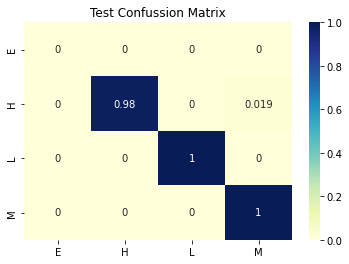

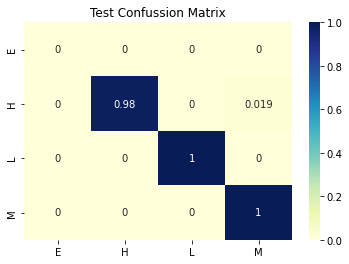

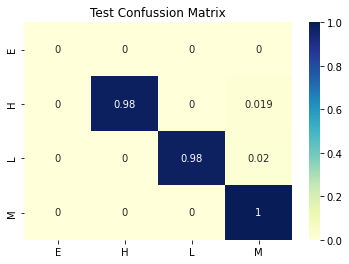

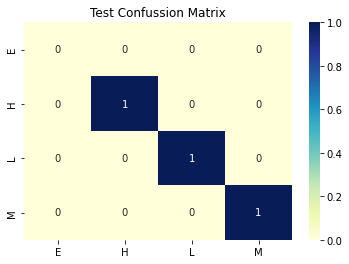

In [5]:
%%time
for k, d in df.items():
    if( k not in exclude ):
        print( 'Dataset ', k, len( d ) )
        grids[ k ] = train_and_test( 
                DecisionTreeClassifier(), params_dt, 
                d[ X_TRAIN ], d[ Y_TRAIN ], 
                d[ X_TEST ], d[ Y_TEST ], 
                plot_cmatrix = True, labels = labels )

# Evaluation

In [6]:
from ml.evaluation import *

## Learning Curves

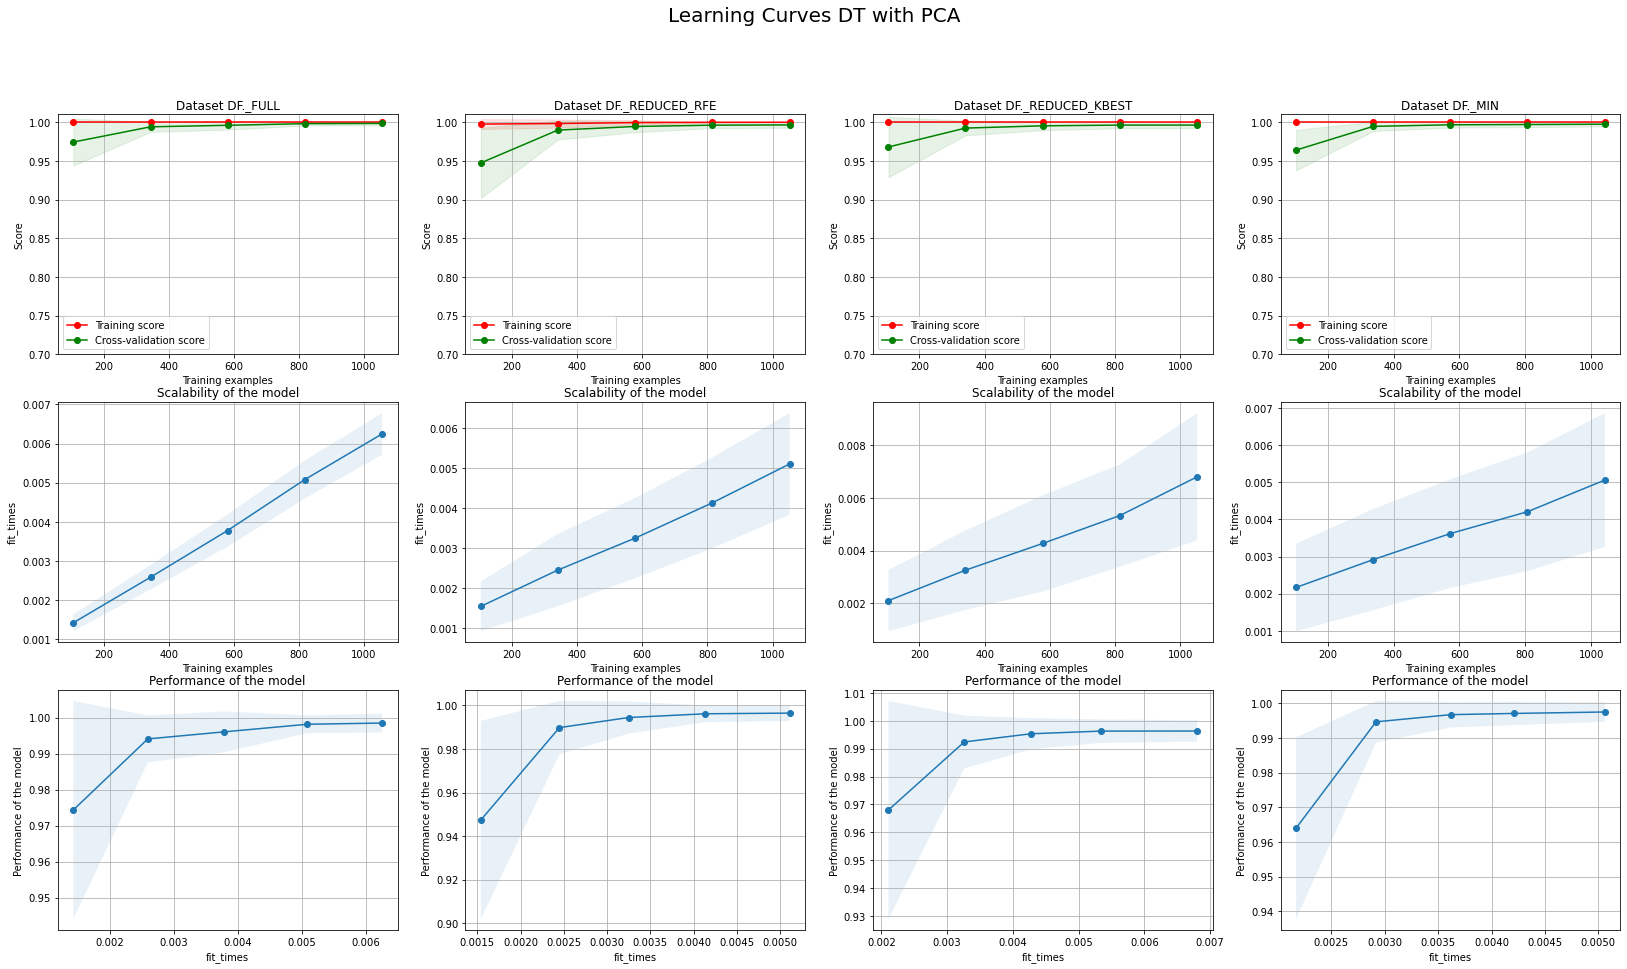

CPU times: user 7.34 s, sys: 575 ms, total: 7.92 s
Wall time: 8.93 s


In [7]:
%%time
temp = [ item for item in df.items() if item[ 0 ] not in exclude ]
plot_learning_curves( temp, grids, 'DT' )